In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [2]:
gamma = 1
beta = 0.99
phi = 1
chi = 1
rho = 0.99
T = 500

Pi = 1

In [3]:
nulist = [0.25, 0.5, 0.99, 2 ,4]

In [4]:
# calibrate theta:
# Assume the long term mean consumption is 0.995, from the data.
Cmean = 0.995

def Cfunc(theta, nu, Cmean):
    return ((1-theta)/chi*((1-theta+theta*(1-beta)**(-(1-nu)/nu)*(theta/(1-theta))**((1-nu)/nu)))**((nu-gamma)/(1-nu)))**(1/(phi+gamma))-Cmean;
thetalist = []
for nu in nulist:
    res = fsolve(Cfunc, 0.02, args=(nu, Cmean))
    thetalist.append(res[0])

print(thetalist)

[0.009919441451885285, 0.00993792684531536, 0.009974257196915831, 0.01004955750974671, 0.010200331253320245]


In [5]:
def mat_calc(nu, theta):

    ## steady state value
    Qss = 1/beta
    Css = ((1-theta)/chi*( (1-theta+theta*(1-beta)**(-(1-nu)/nu)*(theta/(1-theta))**((1-nu)/nu)))**((nu-gamma)/(1-nu)))**(1/(phi+gamma))
    Xss = ( (1-theta+theta*(1-beta)**(-(1-nu)/nu)*(theta/(1-theta))**((1-nu)/nu)) )**(1/(1-nu) ) * Css
    Mss = (1-beta)**(-1/nu) * (theta/(1-theta) )**(1/nu) * Css


    # define sparse identity, above-diagonal sparse matrix, below-diagonal sparse matrix, and zero matrix
    I = sp.sparse.eye(T)
    Ip1 = sp.sparse.diags([np.ones(T-1)], [1], (T, T))
    Im1 = sp.sparse.diags([np.ones(T-1)], [-1], (T, T))
    O = sp.sparse.csr_matrix((T, T))


    ## dHdY
    # Market Clearing Condition
    Phigmy = -I
    Phigmw = O
    Phigmc = I
    Phigmq = O
    Phigmx = O

    # Money FOC
    PhiMFy = O
    PhiMFw = O
    PhiMFc = -I
    PhiMFq = (1/nu)*(beta/(1-beta))*I
    PhiMFx = I

    dHdY = sp.sparse.bmat([[Phigmy, Phigmw, Phigmc, Phigmq, Phigmx],
                           [PhiMFy, PhiMFw, PhiMFc, PhiMFq, PhiMFx]])

    assert dHdY.shape == (2*T, 5*T)  

    ## dYdZ
    Phixm = I
    Phiym = O
    Phiwm = O
    Phicm = (1/((nu - gamma)*(1-theta)*((Css/Xss)**(1-nu)) - nu) )*((theta)*(nu-gamma)*((Mss/Xss)**(1-nu))*Phixm - Phiwm)
    Phiqm = -nu*(I-Ip1)*Phicm + (nu-gamma)*(1-theta)*((Css/Xss)**(1-nu))*(I-Ip1)*Phicm + (nu-gamma)*(theta)*((Mss/Xss)**(1-nu))*(I-Ip1)*Phixm


    dYdZ = sp.sparse.bmat([[Phiym],
                            [Phiwm],
                            [Phicm],
                            [Phiqm],
                            [Phixm]])
    assert dYdZ.shape == (5*T, T)


    ## dYdU
    Phiyn = I
    Phiyp = O

    Phiwn = O
    Phiwp = O

    Phixn = O
    Phixp = -I

    Phicn = (1/((nu - gamma)*(1-theta)*((Css/Xss)**(1-nu)) - nu))*((phi)*I + (theta)*(nu-gamma)*((Mss/Xss)**(1-nu))*Phixn - Phiwn)
    Phicp = (1/((nu - gamma)*(1-theta)*((Css/Xss)**(1-nu)) - nu) )*((theta)*(nu-gamma)*((Mss/Xss)**(1-nu))*Phixp - Phiwp)

    Phiqn = -nu*(I-Ip1)*Phicn + (nu-gamma)*(1-theta)*((Css/Xss)**(1-nu))*(I-Ip1)*Phicn + (nu-gamma)*(theta)*((Mss/Xss)**(1-nu))*(I-Ip1)*Phixn
    Phiqp = -(I-Ip1) - nu*(I-Ip1)*Phicp + (nu-gamma)*(1-theta)*((Css/Xss)**(1-nu))*(I-Ip1)*Phicp + (nu-gamma)*(theta)*((Mss/Xss)**(1-nu))*(I-Ip1)*Phixp


    dYdU = sp.sparse.bmat([[Phiyn, Phiyp],
                            [Phiwn, Phiwp],
                            [Phicn, Phicp],
                            [Phiqn, Phiqp],
                            [Phixn, Phixp]])
    assert dYdU.shape == (5*T, 2*T)


    dHdU = dHdY @ dYdU 
    dHdZ = dHdY @ dYdZ
    assert sp.sparse.issparse(dHdZ) == True
    assert sp.sparse.issparse(dHdU) == True



    assert dHdU.shape == (2*T, 2*T)
    assert dHdZ.shape == (2*T, T)

    dUdZ = - sp.sparse.linalg.spsolve(dHdU, dHdZ)
    dYdZ = dYdU @ dUdZ + dYdZ

    dXdZ = sp.sparse.bmat([[dUdZ],
                          [dYdZ]])

    assert dUdZ.shape == (2*T, T)
    assert dYdZ.shape == (5*T, T)
    assert dXdZ.shape == (7*T, T)

    return dXdZ

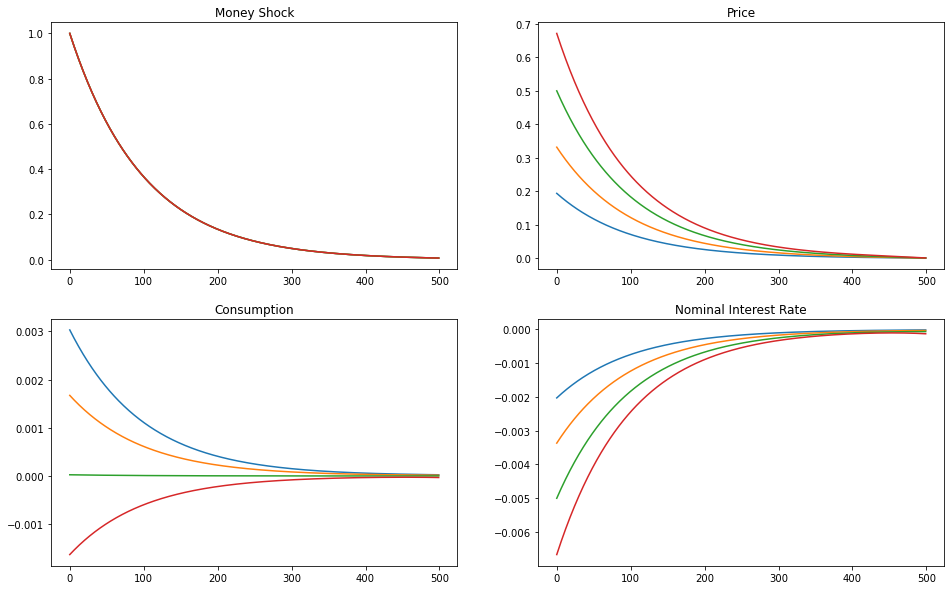

In [7]:
a = np.zeros((T, 1))
a[0] = 1
for t in range(1, T):
    a[t] = rho * a[t-1]
    
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for i in range(4):
    nu = nulist[i]
    theta = thetalist[i]
    dXdZ = mat_calc(nu, theta)
    
    # compute impulse response functions
    X = dXdZ @ a

    # unpack X into its components k,n,c,inv,y,wp,rk
    n = X[0:T]
    p = X[T:2*T]
    y = X[2*T:3*T]
    w = X[3*T:4*T]
    c = X[4*T:5*T]
    q = X[5*T:6*T]
    x = X[6*T:7*T]
    
    ax[0, 0].plot(a, label='a')
    ax[0, 0].set_title('Money Shock')
    ax[0, 1].plot(p, label='p')
    ax[0, 1].set_title('Price')
    ax[1, 0].plot(c, label='c')
    ax[1, 0].set_title('Consumption')
    ax[1, 1].plot(q, label='q')
    ax[1, 1].set_title('Nominal Interest Rate')
    
    plt.savefig('IRFs.png')